In [ ]:
import os
import zipfile
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define Google Drive paths for datasets and CSV files
plant_doc_zip_path = '/content/drive/My Drive/datasets/plantdoc.zip'
plant_village_zip_path = '/content/drive/My Drive/datasets/plantvillage.zip'
train_csv_path = '/content/drive/My Drive/datasets/PV train.csv'
test_seen_csv_path = '/content/drive/My Drive/datasets/PV test seen.csv'
test_unseen_csv_path = '/content/drive/My Drive/datasets/PV test unseen.csv'
plantdoc_unseen_csv_path = '/content/drive/My Drive/datasets/PD test unseen.csv'

# Temporary extraction paths
temp_extract_path = '/content'

# Extract datasets
with zipfile.ZipFile(plant_doc_zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_extract_path)
with zipfile.ZipFile(plant_village_zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_extract_path)

# Paths for extracted datasets
plant_doc_extract_path = '/content/plantdoc' if os.path.exists('/content/plantdoc') else '/content'
plant_village_extract_path = '/content/plantvillage/plantvillage' if os.path.exists('/content/plantvillage/plantvillage') else '/content/plantvillage'

# Load CSV files
train_df = pd.read_csv(train_csv_path, header=None, names=['image', 'crop', 'disease'])
test_seen_df = pd.read_csv(test_seen_csv_path, header=None, names=['image', 'crop', 'disease'])
test_unseen_df = pd.read_csv(test_unseen_csv_path, header=None, names=['image', 'crop', 'disease'])
plantdoc_unseen_df = pd.read_csv(plantdoc_unseen_csv_path, header=None, names=['image', 'crop', 'disease'])

print("Training Data Sample:")
print(train_df.head())


Mounted at /content/drive
Training Data Sample:
                                               image  crop  disease
0  4b22a1e7-745b-4c78-a49e-14ca8cfba26a___RS_HL-8...     0        0
1  9ee2b5e6-46cf-400f-a82f-660a2ac05157___RS_HL-5...     0        0
2  181ce194-fdc9-4f0b-ae8d-0c621f723279___RS_HL-7...     0        0
3  3e8eb97c-b2ad-4aeb-82ff-2f1334801c9b___RS_HL-6...     0        0
4  4e817ac6-818a-431f-af6d-e44477f9b649___RS_HL-7...     0        0


In [ ]:
# Install necessary libraries
!pip install torch torchvision tqdm matplotlib sentence-transformers
!pip install torch torchvision tqdm scikit-learn matplotlib

import os
import zipfile
import pandas as pd
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import normalize
from torch.optim import Adam

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
transform = Compose([Resize((224, 224)), ToTensor()])

# Dataset class
class PlantDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.root_dir, row['image'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        crop_label = int(row['crop'])
        disease_label = int(row['disease'])
        return image, crop_label, disease_label

# Gradient Reversal Layer
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha=1.0):
        ctx.alpha = alpha
        return x

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

# Domain Discriminator
class DomainDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(DomainDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # 2 domains: lab and field
        )

    def forward(self, x):
        return self.model(x)

# Improved model with domain discriminator
class ImprovedDualBranchModelWithDomainDiscriminator(nn.Module):
    def __init__(self, num_crops, num_diseases, embedding_dim, pretrained_embeddings):
        super(ImprovedDualBranchModelWithDomainDiscriminator, self).__init__()
        self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        self.backbone.fc = nn.Identity()

        # Use provided embeddings
        self.crop_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings["crop"], freeze=True)
        self.disease_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings["disease"], freeze=True)

        # Feature projection
        self.feature_projector = nn.Linear(512, embedding_dim)
        self.crop_classifier = nn.Linear(embedding_dim, num_crops)
        self.disease_classifier = nn.Linear(embedding_dim, num_diseases)

        # Domain discriminator
        self.domain_discriminator = DomainDiscriminator(input_dim=embedding_dim)

    def forward(self, x, alpha=1.0):
        features = self.backbone(x)
        projected_features = self.feature_projector(features)
        normalized_features = normalize(projected_features, p=2, dim=1)

        # Crop and disease predictions
        crop_logits = self.crop_classifier(normalized_features)
        disease_logits = self.disease_classifier(normalized_features)

        # Domain prediction with gradient reversal
        reversed_features = GradientReversalFunction.apply(normalized_features, alpha)
        domain_logits = self.domain_discriminator(reversed_features)

        return crop_logits, disease_logits, domain_logits


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:

# Prepare datasets and loaders
train_dataset = PlantDataset(train_df, plant_village_extract_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_seen_dataset = PlantDataset(test_seen_df, plant_village_extract_path, transform=transform)
test_seen_loader = DataLoader(test_seen_dataset, batch_size=32, shuffle=False)

test_unseen_dataset = PlantDataset(test_unseen_df, plant_village_extract_path, transform=transform)
test_unseen_loader = DataLoader(test_unseen_dataset, batch_size=32, shuffle=False)

# Prepare PlantDoc dataset
plantdoc_extract_path = '/content/plantdoc'  # Define the correct PlantDoc extraction path
plantdoc_unseen_dataset = PlantDataset(plantdoc_unseen_df, plantdoc_extract_path, transform=transform)
plantdoc_unseen_loader = DataLoader(plantdoc_unseen_dataset, batch_size=32, shuffle=False)

In [ ]:

# Load pretrained embeddings for crops and diseases
plant_crop_descriptions = {
    0: "Oval-shaped leaves with serrated edges and dark green color",
    1: "Heart-shaped leaves with smooth edges and dark green color",
    2: "Oval-shaped leaves with fine serrations and bright green appearance",
    3: "Broad leaves with a smooth texture and parallel veins",
    4: "Lobed-shaped leaves with serrated edges and green surface",
    5: "Round-shaped leaves with smooth edges and glossy green color",
    6: "Yellowish leaves with elliptical shape and serrated edges",
    7: "Heart-shaped leaves with smooth edges and deep green tone",
    8: "Heart-shaped leaves with textured veins and vibrant green color",
    9: "Heart-shaped leaves with serrated edges and bright green hue",
    10: "Smooth-textured leaves that are heart-shaped with medium green color",
    11: "Lobed-shaped leaves with rough texture and pale green color",
    12: "Oval-shaped leaves with serrated edges and multicolored green and red tones",
    13: "Elongated-shaped leaves with uneven edges and green tones"
}

plant_disease_descriptions = {
    0: "Healthy leaf with no visible disease signs",
    1: "Leaf with spotted appearance indicating potential fungal infection",
    2: "Brown spots distributed unevenly, showing slight discoloration",
    3: "Brown spots with irregular patterns and surrounding discoloration",
    4: "White patches with powdery texture, signs of fungal infection",
    5: "Brown streaks and specks, potentially indicating rust disease",
    6: "Dense brown specks, highly suggestive of rust infection",
    7: "Large brown patches with necrosis, indicative of fungal infection",
    8: "Brown specks with white lesions, evident disease presence",
    9: "Dark spots and edge browning, showing severe infection",
    10: "Yellowing patches on the leaf, potentially nutrient deficiency",
    11: "Yellowing leaf with black spots indicating fungal infection",
    12: "Dark lesions with irregular patches, advanced infection symptoms",
    13: "Brown patches and curling edges, clear signs of disease",
    14: "Red-brown spots with perforations, indicating severe infection",
    15: "Yellowing and uneven chlorosis, potentially nutrient deficiency",
    16: "Yellowing with black spots, early signs of infection",
    17: "Dark spots and curling edges, indicating potential infection",
    18: "Dry patches and discoloration, showing signs of stress",
    19: "Yellowing leaf with vein chlorosis, possible nutrient deficiency",
    20: "Green leaf with mild curling, indicating potential stress signs"
}


In [ ]:

# Generate embeddings
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')
crop_embeddings = torch.tensor(embedding_model.encode(list(plant_crop_descriptions.values())), dtype=torch.float32)
disease_embeddings = torch.tensor(embedding_model.encode(list(plant_disease_descriptions.values())), dtype=torch.float32)

# Transfer embeddings to GPU
crop_embeddings = crop_embeddings.to(device)
disease_embeddings = disease_embeddings.to(device)

# Prepare pretrained embeddings
pretrained_embeddings = {
    "crop": crop_embeddings,
    "disease": disease_embeddings
}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:

# Initialize model
num_crops = len(plant_crop_descriptions)
num_diseases = len(plant_disease_descriptions)
embedding_dim = crop_embeddings.shape[1]
model = ImprovedDualBranchModelWithDomainDiscriminator(num_crops, num_diseases, embedding_dim, pretrained_embeddings).to(device)

# Loss functions
classification_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = Adam(model.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


In [ ]:
from torch.utils.data import random_split
import numpy as np
from tqdm import tqdm

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Training loop with validation and early stopping
num_epochs = 50
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    correct_crop = 0
    correct_disease = 0
    total = 0

    for images, crop_labels, disease_labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        images, crop_labels, disease_labels = images.to(device), crop_labels.to(device), disease_labels.to(device)

        optimizer.zero_grad()
        crop_logits, disease_logits, domain_logits = model(images)

        loss_crop = classification_criterion(crop_logits, crop_labels)
        loss_disease = classification_criterion(disease_logits, disease_labels)

        loss = loss_crop + loss_disease
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted_crops = torch.max(crop_logits, 1)
        _, predicted_diseases = torch.max(disease_logits, 1)

        correct_crop += (predicted_crops == crop_labels).sum().item()
        correct_disease += (predicted_diseases == disease_labels).sum().item()
        total += crop_labels.size(0)

    train_loss /= len(train_loader)
    train_acc = (correct_crop + correct_disease) / (2 * total)

    # Validation
    model.eval()
    val_loss = 0
    correct_crop = 0
    correct_disease = 0
    total = 0

    with torch.no_grad():
        for images, crop_labels, disease_labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
            images, crop_labels, disease_labels = images.to(device), crop_labels.to(device), disease_labels.to(device)

            crop_logits, disease_logits, domain_logits = model(images)

            loss_crop = classification_criterion(crop_logits, crop_labels)
            loss_disease = classification_criterion(disease_logits, disease_labels)

            loss = loss_crop + loss_disease
            val_loss += loss.item()

            _, predicted_crops = torch.max(crop_logits, 1)
            _, predicted_diseases = torch.max(disease_logits, 1)

            correct_crop += (predicted_crops == crop_labels).sum().item()
            correct_disease += (predicted_diseases == disease_labels).sum().item()
            total += crop_labels.size(0)

    val_loss /= len(val_loader)
    val_acc = (correct_crop + correct_disease) / (2 * total)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

    # Log metrics
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


# Save the best model
torch.save(model, "best_model_with_domain.pth")
print("Best model saved successfully.")

Epoch 1/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 13.16it/s]


Epoch 1/50
Train Loss: 1.8101, Train Acc: 0.7771
Val Loss: 0.9839, Val Acc: 0.8538


Epoch 2/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 13.06it/s]


Epoch 2/50
Train Loss: 0.5138, Train Acc: 0.9314
Val Loss: 0.4157, Val Acc: 0.9385


Epoch 3/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 12.96it/s]


Epoch 3/50
Train Loss: 0.2421, Train Acc: 0.9686
Val Loss: 0.1938, Val Acc: 0.9738


Epoch 4/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 12.86it/s]


Epoch 4/50
Train Loss: 0.1587, Train Acc: 0.9786
Val Loss: 0.1031, Val Acc: 0.9872


Epoch 5/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 13.23it/s]


Epoch 5/50
Train Loss: 0.1101, Train Acc: 0.9845
Val Loss: 0.1127, Val Acc: 0.9837


Epoch 6/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 12.98it/s]


Epoch 6/50
Train Loss: 0.0962, Train Acc: 0.9864
Val Loss: 0.0986, Val Acc: 0.9862


Epoch 7/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 12.93it/s]


Epoch 7/50
Train Loss: 0.0729, Train Acc: 0.9894
Val Loss: 0.0875, Val Acc: 0.9875


Epoch 8/50 - Validation: 100%|██████████| 244/244 [00:19<00:00, 12.69it/s]


Epoch 8/50
Train Loss: 0.0787, Train Acc: 0.9885
Val Loss: 0.0658, Val Acc: 0.9892


Epoch 9/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 13.21it/s]


Epoch 9/50
Train Loss: 0.0486, Train Acc: 0.9929
Val Loss: 0.1042, Val Acc: 0.9846


Epoch 10/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 12.90it/s]


Epoch 10/50
Train Loss: 0.0473, Train Acc: 0.9931
Val Loss: 0.1538, Val Acc: 0.9785


Epoch 11/50 - Validation: 100%|██████████| 244/244 [00:19<00:00, 12.72it/s]


Epoch 11/50
Train Loss: 0.0645, Train Acc: 0.9901
Val Loss: 0.0542, Val Acc: 0.9918


Epoch 12/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 13.04it/s]


Epoch 12/50
Train Loss: 0.0380, Train Acc: 0.9944
Val Loss: 0.0677, Val Acc: 0.9899


Epoch 13/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 12.94it/s]


Epoch 13/50
Train Loss: 0.0342, Train Acc: 0.9951
Val Loss: 0.1347, Val Acc: 0.9806


Epoch 14/50 - Validation: 100%|██████████| 244/244 [00:19<00:00, 12.84it/s]


Epoch 14/50
Train Loss: 0.0470, Train Acc: 0.9929
Val Loss: 0.0423, Val Acc: 0.9932


Epoch 15/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 13.11it/s]


Epoch 15/50
Train Loss: 0.0277, Train Acc: 0.9960
Val Loss: 0.0732, Val Acc: 0.9897


Epoch 16/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 12.99it/s]


Epoch 16/50
Train Loss: 0.0361, Train Acc: 0.9945
Val Loss: 0.1443, Val Acc: 0.9801


Epoch 17/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 13.16it/s]


Epoch 17/50
Train Loss: 0.0376, Train Acc: 0.9943
Val Loss: 0.0925, Val Acc: 0.9859


Epoch 18/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 12.97it/s]


Epoch 18/50
Train Loss: 0.0246, Train Acc: 0.9959
Val Loss: 0.0608, Val Acc: 0.9909


Epoch 19/50 - Validation: 100%|██████████| 244/244 [00:18<00:00, 12.85it/s]


Early stopping triggered
Best model saved successfully.


**Save model to drive**

In [ ]:
# Save the best model
torch.save(model.state_dict(), "best_model_with_domain.pth")

# Save to a specific location (e.g., Google Drive)
model_save_path = '/content/drive/My Drive/best_model_with_domain.pth'
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at {model_save_path}")


Model saved at /content/drive/My Drive/best_model_with_domain.pth


**Evaluation**

In [ ]:
def evaluate_model(model, data_loader, dataset_name):
    model.eval()  # Set model to evaluation mode
    total_crop_loss = 0
    total_disease_loss = 0
    correct_crop = 0
    correct_disease = 0
    total_samples = 0

    with torch.no_grad():
        for images, crop_labels, disease_labels in tqdm(data_loader, desc=f"Evaluating on {dataset_name}"):
            images, crop_labels, disease_labels = images.to(device), crop_labels.to(device), disease_labels.to(device)

            # Forward pass
            crop_logits, disease_logits, domain_logits = model(images)

            # Calculate losses
            loss_crop = classification_criterion(crop_logits, crop_labels)
            loss_disease = classification_criterion(disease_logits, disease_labels)

            total_crop_loss += loss_crop.item()
            total_disease_loss += loss_disease.item()

            # Calculate accuracy
            _, predicted_crops = torch.max(crop_logits, 1)
            _, predicted_diseases = torch.max(disease_logits, 1)

            correct_crop += (predicted_crops == crop_labels).sum().item()
            correct_disease += (predicted_diseases == disease_labels).sum().item()
            total_samples += crop_labels.size(0)

    # Compute average losses and accuracies
    avg_crop_loss = total_crop_loss / len(data_loader)
    avg_disease_loss = total_disease_loss / len(data_loader)

    crop_accuracy = correct_crop / total_samples
    disease_accuracy = correct_disease / total_samples

    # Print results
    print(f"Dataset: {dataset_name}")
    print(f"Crop Loss: {avg_crop_loss:.4f}, Crop Accuracy: {crop_accuracy:.4f}")
    print(f"Disease Loss: {avg_disease_loss:.4f}, Disease Accuracy: {disease_accuracy:.4f}")
    return avg_crop_loss, avg_disease_loss, crop_accuracy, disease_accuracy

# Evaluate on PV test seen
evaluate_model(model, test_seen_loader, "PV Test Seen")

# Evaluate on PV test unseen
evaluate_model(model, test_unseen_loader, "PV Test Unseen")

# Evaluate on PD test unseen
evaluate_model(model, plantdoc_unseen_loader, "PD Test Unseen")


Evaluating on PV Test Seen: 100%|██████████| 322/322 [00:25<00:00, 12.64it/s]


Dataset: PV Test Seen
Crop Loss: 0.0297, Crop Accuracy: 0.9922
Disease Loss: 0.0984, Disease Accuracy: 0.9702


Evaluating on PV Test Unseen: 100%|██████████| 7/7 [00:00<00:00, 12.78it/s]


Dataset: PV Test Unseen
Crop Loss: 6.1332, Crop Accuracy: 0.1759
Disease Loss: 6.3303, Disease Accuracy: 0.1574


Evaluating on PD Test Unseen: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

Dataset: PD Test Unseen
Crop Loss: 8.5570, Crop Accuracy: 0.0282
Disease Loss: 9.1408, Disease Accuracy: 0.0423


(8.557040532430014,
 9.140838940938314,
 0.028169014084507043,
 0.04225352112676056)

Top-N accuracy

In [ ]:
def evaluate_top_k_accuracy(model, data_loader, dataset_name, k=5):
    model.eval()  # Set the model to evaluation mode
    correct_top1_crop = 0
    correct_top5_crop = 0
    correct_top1_disease = 0
    correct_top5_disease = 0
    total_samples = 0

    with torch.no_grad():
        for images, crop_labels, disease_labels in tqdm(data_loader, desc=f"Evaluating {dataset_name}"):
            images, crop_labels, disease_labels = images.to(device), crop_labels.to(device), disease_labels.to(device)

            # Forward pass
            crop_logits, disease_logits, _ = model(images)

            # Top-1 Accuracy
            _, predicted_crops = torch.max(crop_logits, 1)
            _, predicted_diseases = torch.max(disease_logits, 1)
            correct_top1_crop += (predicted_crops == crop_labels).sum().item()
            correct_top1_disease += (predicted_diseases == disease_labels).sum().item()

            # Top-K Accuracy
            crop_topk = torch.topk(crop_logits, k, dim=1).indices
            disease_topk = torch.topk(disease_logits, k, dim=1).indices
            correct_top5_crop += sum([crop_labels[i] in crop_topk[i] for i in range(len(crop_labels))])
            correct_top5_disease += sum([disease_labels[i] in disease_topk[i] for i in range(len(disease_labels))])

            total_samples += crop_labels.size(0)

    # Compute accuracies
    top1_crop_acc = correct_top1_crop / total_samples
    top5_crop_acc = correct_top5_crop / total_samples
    top1_disease_acc = correct_top1_disease / total_samples
    top5_disease_acc = correct_top5_disease / total_samples

    print(f"Dataset: {dataset_name}")
    print(f"Top-1 Crop Accuracy: {top1_crop_acc:.4f}, Top-5 Crop Accuracy: {top5_crop_acc:.4f}")
    print(f"Top-1 Disease Accuracy: {top1_disease_acc:.4f}, Top-5 Disease Accuracy: {top5_disease_acc:.4f}")

    return top1_crop_acc, top5_crop_acc, top1_disease_acc, top5_disease_acc

# Example usage:
evaluate_top_k_accuracy(model, test_seen_loader, "PV Test Seen")
evaluate_top_k_accuracy(model, test_unseen_loader, "PV Test Unseen")
evaluate_top_k_accuracy(model, plantdoc_unseen_loader, "PD Test Unseen")


Evaluating PV Test Seen: 100%|██████████| 322/322 [00:26<00:00, 12.32it/s]


Dataset: PV Test Seen
Top-1 Crop Accuracy: 0.9922, Top-5 Crop Accuracy: 0.9996
Top-1 Disease Accuracy: 0.9702, Top-5 Disease Accuracy: 0.9998


Evaluating PV Test Unseen: 100%|██████████| 7/7 [00:00<00:00, 12.54it/s]


Dataset: PV Test Unseen
Top-1 Crop Accuracy: 0.1759, Top-5 Crop Accuracy: 0.8056
Top-1 Disease Accuracy: 0.1574, Top-5 Disease Accuracy: 0.5370


Evaluating PD Test Unseen: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

Dataset: PD Test Unseen
Top-1 Crop Accuracy: 0.0282, Top-5 Crop Accuracy: 0.2958
Top-1 Disease Accuracy: 0.0423, Top-5 Disease Accuracy: 0.1831


(0.028169014084507043,
 0.29577464788732394,
 0.04225352112676056,
 0.18309859154929578)

Harmonic Mean Between Seen and Unseen

In [ ]:
def harmonic_mean(acc_seen, acc_unseen):
    return 2 * (acc_seen * acc_unseen) / (acc_seen + acc_unseen)

# Compute harmonic mean
top1_seen_crop, _, top1_seen_disease, _ = evaluate_top_k_accuracy(model, test_seen_loader, "PV Test Seen", k=1)
top1_unseen_crop, _, top1_unseen_disease, _ = evaluate_top_k_accuracy(model, test_unseen_loader, "PV Test Unseen", k=1)

harmonic_crop = harmonic_mean(top1_seen_crop, top1_unseen_crop)
harmonic_disease = harmonic_mean(top1_seen_disease, top1_unseen_disease)

print(f"Harmonic Mean for Crops: {harmonic_crop:.4f}")
print(f"Harmonic Mean for Diseases: {harmonic_disease:.4f}")


Evaluating PV Test Seen: 100%|██████████| 322/322 [00:26<00:00, 12.30it/s]


Dataset: PV Test Seen
Top-1 Crop Accuracy: 0.9922, Top-5 Crop Accuracy: 0.9922
Top-1 Disease Accuracy: 0.9702, Top-5 Disease Accuracy: 0.9702


Evaluating PV Test Unseen: 100%|██████████| 7/7 [00:00<00:00, 12.41it/s]

Dataset: PV Test Unseen
Top-1 Crop Accuracy: 0.1759, Top-5 Crop Accuracy: 0.1759
Top-1 Disease Accuracy: 0.1574, Top-5 Disease Accuracy: 0.1574
Harmonic Mean for Crops: 0.2989
Harmonic Mean for Diseases: 0.2709


Confusion Matrix for Seen

Generating Confusion Matrix for PV Test Seen: 100%|██████████| 322/322 [00:25<00:00, 12.61it/s]


PV Test Seen - Crop Confusion Matrix


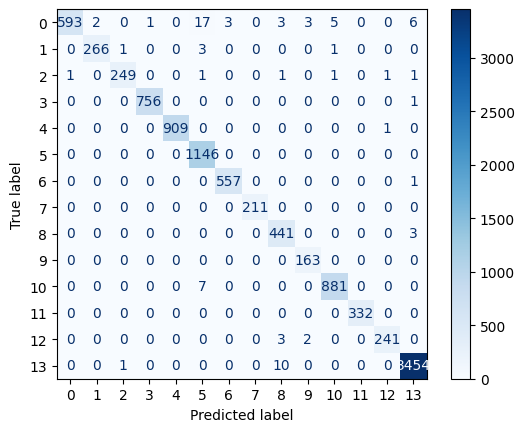

PV Test Seen - Disease Confusion Matrix


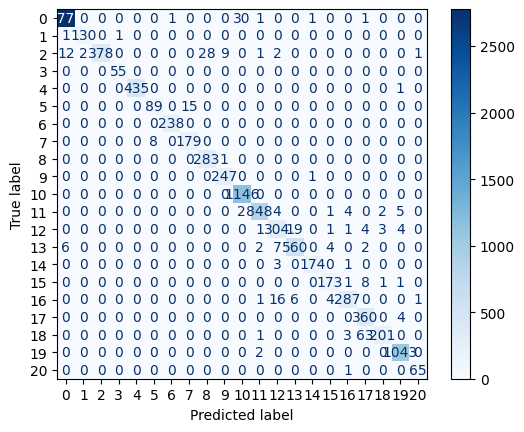

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def generate_confusion_matrix(model, data_loader, dataset_name):
    model.eval()
    all_true_crop = []
    all_pred_crop = []
    all_true_disease = []
    all_pred_disease = []

    with torch.no_grad():
        for images, crop_labels, disease_labels in tqdm(data_loader, desc=f"Generating Confusion Matrix for {dataset_name}"):
            images, crop_labels, disease_labels = images.to(device), crop_labels.to(device), disease_labels.to(device)

            crop_logits, disease_logits, _ = model(images)
            _, predicted_crops = torch.max(crop_logits, 1)
            _, predicted_diseases = torch.max(disease_logits, 1)

            all_true_crop.extend(crop_labels.cpu().numpy())
            all_pred_crop.extend(predicted_crops.cpu().numpy())
            all_true_disease.extend(disease_labels.cpu().numpy())
            all_pred_disease.extend(predicted_diseases.cpu().numpy())

    # Confusion Matrices
    crop_cm = confusion_matrix(all_true_crop, all_pred_crop)
    disease_cm = confusion_matrix(all_true_disease, all_pred_disease)

    print(f"{dataset_name} - Crop Confusion Matrix")
    display = ConfusionMatrixDisplay(crop_cm, display_labels=np.arange(len(crop_cm)))
    display.plot(cmap='Blues')
    plt.show()

    print(f"{dataset_name} - Disease Confusion Matrix")
    display = ConfusionMatrixDisplay(disease_cm, display_labels=np.arange(len(disease_cm)))
    display.plot(cmap='Blues')
    plt.show()

# Example usage:
generate_confusion_matrix(model, test_seen_loader, "PV Test Seen")


** Use unseen data to extract features and evaluate the model's performance. **

In [ ]:
def extract_features(model, data_loader, dataset_name):
    model.eval()  # Set model to evaluation mode
    features = []
    crop_labels = []
    disease_labels = []

    with torch.no_grad():
        for images, crop_label, disease_label in tqdm(data_loader, desc=f"Extracting features from {dataset_name}"):
            images = images.to(device)
            crop_label = crop_label.to(device)
            disease_label = disease_label.to(device)

            # Extract features from the backbone
            features_batch = model.backbone(images)

            # Save features and labels
            features.append(features_batch.cpu())
            crop_labels.append(crop_label.cpu())
            disease_labels.append(disease_label.cpu())

    # Combine features and labels into single tensors
    features = torch.cat(features, dim=0)
    crop_labels = torch.cat(crop_labels, dim=0)
    disease_labels = torch.cat(disease_labels, dim=0)

    print(f"Features extracted from {dataset_name}: {features.shape}")
    return features, crop_labels, disease_labels


In [ ]:
def evaluate_features(features, crop_labels, disease_labels, model, k=5):
    model.eval()

    correct_top1_crop = 0
    correct_top5_crop = 0
    correct_top1_disease = 0
    correct_top5_disease = 0

    with torch.no_grad():
        for i in range(features.size(0)):
            # Process features using the feature projector and normalization
            feature = features[i].unsqueeze(0).to(device)
            projected_feature = model.feature_projector(feature)
            normalized_feature = torch.nn.functional.normalize(projected_feature, p=2, dim=1)

            # Crop and disease classification
            crop_logits = model.crop_classifier(normalized_feature)
            disease_logits = model.disease_classifier(normalized_feature)

            # Top-1 Accuracy
            _, predicted_crop = torch.max(crop_logits, 1)
            _, predicted_disease = torch.max(disease_logits, 1)

            correct_top1_crop += (predicted_crop == crop_labels[i].to(device)).item()
            correct_top1_disease += (predicted_disease == disease_labels[i].to(device)).item()

            # Top-K Accuracy
            crop_topk = torch.topk(crop_logits, k, dim=1).indices[0]  # Get top-K indices for crops
            disease_topk = torch.topk(disease_logits, k, dim=1).indices[0]  # Get top-K indices for diseases

            correct_top5_crop += crop_labels[i].item() in crop_topk.cpu().numpy()
            correct_top5_disease += disease_labels[i].item() in disease_topk.cpu().numpy()

    total_samples = features.size(0)

    top1_crop_acc = correct_top1_crop / total_samples
    top5_crop_acc = correct_top5_crop / total_samples
    top1_disease_acc = correct_top1_disease / total_samples
    top5_disease_acc = correct_top5_disease / total_samples

    print(f"Top-1 Crop Accuracy: {top1_crop_acc:.4f}, Top-5 Crop Accuracy: {top5_crop_acc:.4f}")
    print(f"Top-1 Disease Accuracy: {top1_disease_acc:.4f}, Top-5 Disease Accuracy: {top5_disease_acc:.4f}")

    return top1_crop_acc, top5_crop_acc, top1_disease_acc, top5_disease_acc


In [ ]:
# Extract features for unseen datasets
pv_test_unseen_features, pv_test_unseen_crop_labels, pv_test_unseen_disease_labels = extract_features(
    model, test_unseen_loader, "PV Test Unseen"
)

pd_test_unseen_features, pd_test_unseen_crop_labels, pd_test_unseen_disease_labels = extract_features(
    model, plantdoc_unseen_loader, "PD Test Unseen"
)

# Evaluate performance on extracted features
print("\nEvaluating on PV Test Unseen:")
evaluate_features(pv_test_unseen_features, pv_test_unseen_crop_labels, pv_test_unseen_disease_labels, model)

print("\nEvaluating on PD Test Unseen:")
evaluate_features(pd_test_unseen_features, pd_test_unseen_crop_labels, pd_test_unseen_disease_labels, model)


Extracting features from PV Test Unseen: 100%|██████████| 7/7 [00:00<00:00, 13.27it/s]


Features extracted from PV Test Unseen: torch.Size([216, 512])


Extracting features from PD Test Unseen: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Features extracted from PD Test Unseen: torch.Size([71, 512])

Evaluating on PV Test Unseen:
Top-1 Crop Accuracy: 0.1759, Top-5 Crop Accuracy: 0.8056
Top-1 Disease Accuracy: 0.1574, Top-5 Disease Accuracy: 0.5370

Evaluating on PD Test Unseen:
Top-1 Crop Accuracy: 0.0282, Top-5 Crop Accuracy: 0.2958
Top-1 Disease Accuracy: 0.0423, Top-5 Disease Accuracy: 0.1831


(0.028169014084507043,
 0.29577464788732394,
 0.04225352112676056,
 0.18309859154929578)

test seen

In [ ]:
# Extract features for PV Test Seen
pv_test_seen_features, pv_test_seen_crop_labels, pv_test_seen_disease_labels = extract_features(
    model, test_seen_loader, "PV Test Seen"
)

# Evaluate performance on PV Test Seen
print("\nEvaluating on PV Test Seen:")
evaluate_features(pv_test_seen_features, pv_test_seen_crop_labels, pv_test_seen_disease_labels, model)


Extracting features from PV Test Seen: 100%|██████████| 322/322 [00:25<00:00, 12.74it/s]


Features extracted from PV Test Seen: torch.Size([10279, 512])

Evaluating on PV Test Seen:
Top-1 Crop Accuracy: 0.9922, Top-5 Crop Accuracy: 0.9996
Top-1 Disease Accuracy: 0.9702, Top-5 Disease Accuracy: 0.9998


(0.992217141745306, 0.9996108570872653, 0.9702305671757953, 0.9998054285436326)

Save with .h

In [ ]:
# Save the entire model
torch.save(model.state_dict(), 'best_model_with_domain.pth')


In [ ]:
# Save to a specific location (e.g., Google Drive)
model_save_path = '/content/drive/My Drive/best_model_with_domain.pth'
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at {model_save_path}")

Model saved at /content/drive/My Drive/best_model_with_domain.pth
